## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp019'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 3 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:299: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

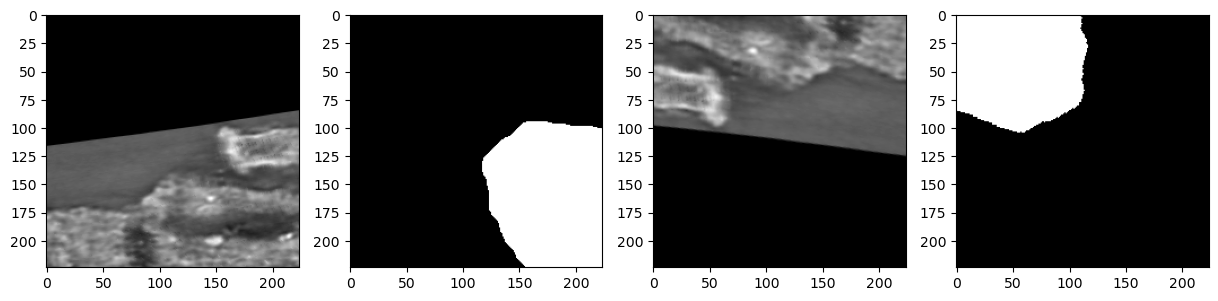

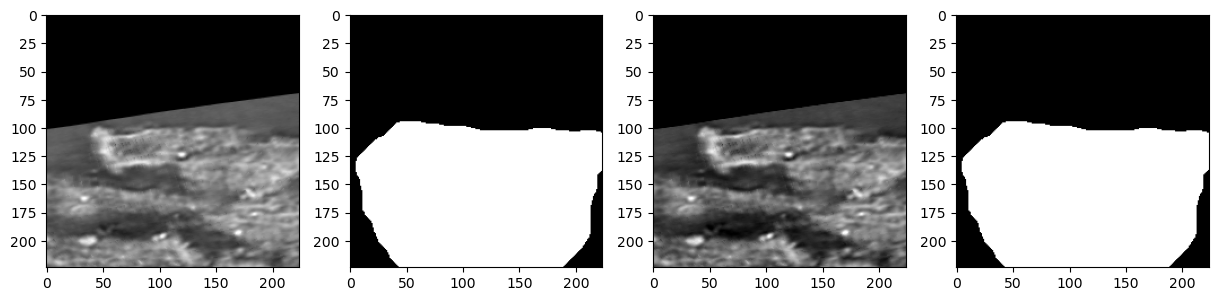

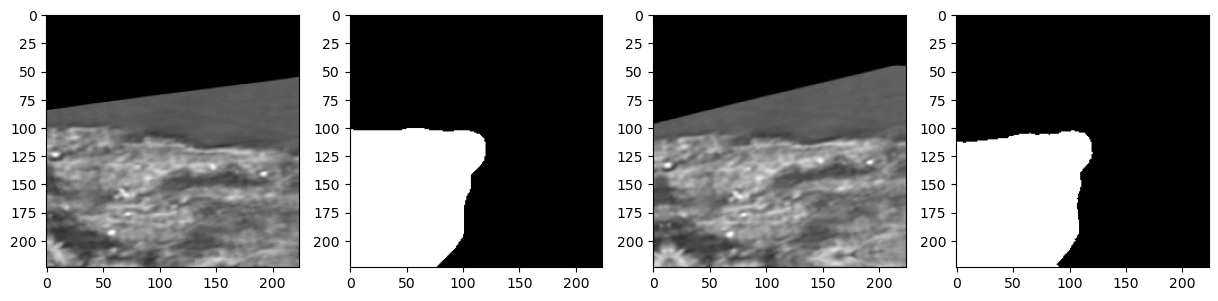

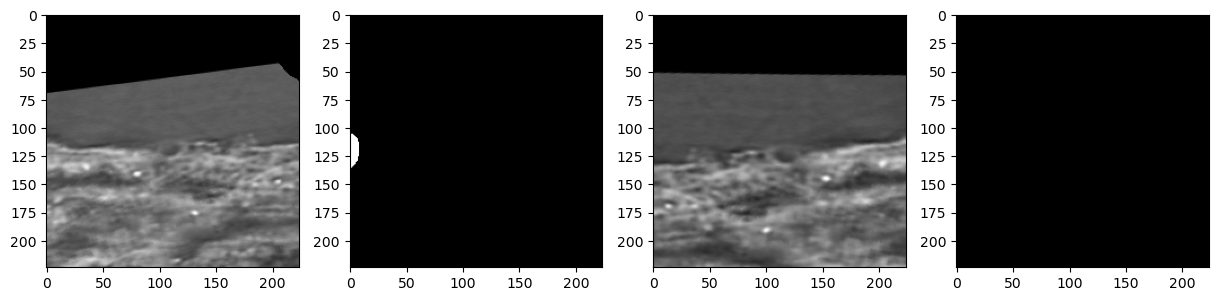

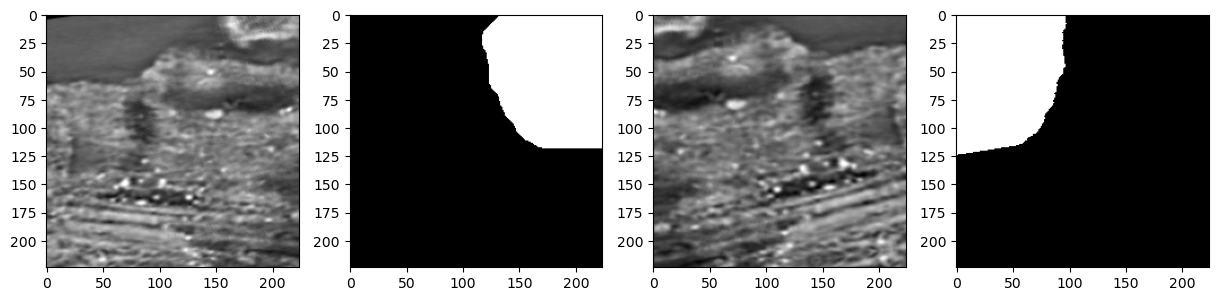

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48140

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.09501534385588276
th: 0.15, fbeta: 0.09504967543902922
th: 0.2, fbeta: 0.135307511105096
th: 0.25, fbeta: 0.15807920447890417
th: 0.3, fbeta: 0.20997729842147217
th: 0.35, fbeta: 0.2940957103378777
th: 0.4, fbeta: 0.3576639860070505
th: 0.45, fbeta: 0.39479872429260493


best_th: 0.5, fbeta: 0.41538466851139527
Epoch 1 - avg_train_loss: 0.5652  avg_val_loss: 0.3806  time: 157s
Epoch 1 - avgScore: 0.4154
Epoch 1 - Save Best Score: 0.4154 Model
Epoch 1 - Save Best Loss: 0.3806 Model


th: 0.5, fbeta: 0.41538466851139527


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.09503995811580389
th: 0.15, fbeta: 0.14555993512350165
th: 0.2, fbeta: 0.17417970557855797
th: 0.25, fbeta: 0.2880163668143119
th: 0.3, fbeta: 0.355762018620289
th: 0.35, fbeta: 0.3955494484916935
th: 0.4, fbeta: 0.42890166183786754
th: 0.45, fbeta: 0.45307842139848314


best_th: 0.5, fbeta: 0.4689298897523862
Epoch 2 - avg_train_loss: 0.3815  avg_val_loss: 0.3064  time: 159s
Epoch 2 - avgScore: 0.4689
Epoch 2 - Save Best Score: 0.4689 Model
Epoch 2 - Save Best Loss: 0.3064 Model


th: 0.5, fbeta: 0.4689298897523862


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.22236611276662405
th: 0.15, fbeta: 0.28930826239418594
th: 0.2, fbeta: 0.357423094255185
th: 0.25, fbeta: 0.4150559944874074
th: 0.3, fbeta: 0.4547967639957193
th: 0.35, fbeta: 0.4819863125236664
th: 0.4, fbeta: 0.50102553432485
th: 0.45, fbeta: 0.5164821459697366


best_th: 0.5, fbeta: 0.5260165510857768
Epoch 3 - avg_train_loss: 0.2911  avg_val_loss: 0.2014  time: 158s
Epoch 3 - avgScore: 0.5260
Epoch 3 - Save Best Score: 0.5260 Model
Epoch 3 - Save Best Loss: 0.2014 Model


th: 0.5, fbeta: 0.5260165510857768


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31052285083169706
th: 0.15, fbeta: 0.36496436851170067
th: 0.2, fbeta: 0.40308369743010175
th: 0.25, fbeta: 0.43467593293854884
th: 0.3, fbeta: 0.4622717282613254
th: 0.35, fbeta: 0.48581970932718394
th: 0.4, fbeta: 0.5052033334617957
th: 0.45, fbeta: 0.5251787258498416


best_th: 0.5, fbeta: 0.5410444109691326
Epoch 4 - avg_train_loss: 0.2550  avg_val_loss: 0.1941  time: 159s
Epoch 4 - avgScore: 0.5410
Epoch 4 - Save Best Score: 0.5410 Model
Epoch 4 - Save Best Loss: 0.1941 Model


th: 0.5, fbeta: 0.5410444109691326


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3163550768671845
th: 0.15, fbeta: 0.36887170457440827
th: 0.2, fbeta: 0.42168562150035643
th: 0.25, fbeta: 0.46726864149026937
th: 0.3, fbeta: 0.5112863971707876
th: 0.35, fbeta: 0.5507118203255384
th: 0.4, fbeta: 0.5825158479157564
th: 0.45, fbeta: 0.6041622691039029


best_th: 0.5, fbeta: 0.6073333409566151
Epoch 5 - avg_train_loss: 0.2412  avg_val_loss: 0.1775  time: 159s
Epoch 5 - avgScore: 0.6073
Epoch 5 - Save Best Score: 0.6073 Model
Epoch 5 - Save Best Loss: 0.1775 Model


th: 0.5, fbeta: 0.6073333409566151


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2570692265142172
th: 0.15, fbeta: 0.2901455002997473
th: 0.2, fbeta: 0.3212155726490052
th: 0.25, fbeta: 0.3569023295831071
th: 0.3, fbeta: 0.40213568009152506
th: 0.35, fbeta: 0.4494527727850555
th: 0.4, fbeta: 0.4834892594659767
th: 0.45, fbeta: 0.5106553793592322


best_th: 0.5, fbeta: 0.5321125943351909
Epoch 6 - avg_train_loss: 0.2305  avg_val_loss: 0.2138  time: 158s
Epoch 6 - avgScore: 0.5321


th: 0.5, fbeta: 0.5321125943351909


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40169197660100897
th: 0.15, fbeta: 0.4658849790815007
th: 0.2, fbeta: 0.5115254689444144
th: 0.25, fbeta: 0.546730339079609
th: 0.3, fbeta: 0.569456991865031
th: 0.35, fbeta: 0.5865182331994145
th: 0.4, fbeta: 0.5960114089535018
th: 0.45, fbeta: 0.5982821699987532


best_th: 0.45, fbeta: 0.5982821699987532
Epoch 7 - avg_train_loss: 0.2201  avg_val_loss: 0.1907  time: 159s
Epoch 7 - avgScore: 0.5983


th: 0.5, fbeta: 0.595611714186766


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38068046141493267
th: 0.15, fbeta: 0.4553681621638432
th: 0.2, fbeta: 0.5014996111987912
th: 0.25, fbeta: 0.5350640703395154
th: 0.3, fbeta: 0.5582615096932791
th: 0.35, fbeta: 0.5739458497395901
th: 0.4, fbeta: 0.5851743336331863
th: 0.45, fbeta: 0.5912716192369264


best_th: 0.5, fbeta: 0.5924964708538587
Epoch 8 - avg_train_loss: 0.2087  avg_val_loss: 0.1833  time: 162s
Epoch 8 - avgScore: 0.5925


th: 0.5, fbeta: 0.5924964708538587


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2661045218026898
th: 0.15, fbeta: 0.30516278049417805
th: 0.2, fbeta: 0.33973430530840515
th: 0.25, fbeta: 0.3700130197979883
th: 0.3, fbeta: 0.39668715550164807
th: 0.35, fbeta: 0.42267061255951666
th: 0.4, fbeta: 0.44713697210839093
th: 0.45, fbeta: 0.4683457539786407


best_th: 0.5, fbeta: 0.4900950474459495
Epoch 9 - avg_train_loss: 0.1983  avg_val_loss: 0.2284  time: 162s
Epoch 9 - avgScore: 0.4901


th: 0.5, fbeta: 0.4900950474459495


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37518627742471466
th: 0.15, fbeta: 0.4265878219342858
th: 0.2, fbeta: 0.46941642305982373
th: 0.25, fbeta: 0.4995543656795322
th: 0.3, fbeta: 0.5229132001221451
th: 0.35, fbeta: 0.540819142247468
th: 0.4, fbeta: 0.5527294960418663
th: 0.45, fbeta: 0.5585362937113479


best_th: 0.5, fbeta: 0.5606985065305772
Epoch 10 - avg_train_loss: 0.1875  avg_val_loss: 0.1990  time: 161s
Epoch 10 - avgScore: 0.5607


th: 0.5, fbeta: 0.5606985065305772


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29573035829919353
th: 0.15, fbeta: 0.33945361997675066
th: 0.2, fbeta: 0.377395064163425
th: 0.25, fbeta: 0.4125880545830425
th: 0.3, fbeta: 0.44548417340664953
th: 0.35, fbeta: 0.4767876189890819
th: 0.4, fbeta: 0.5010719004204628
th: 0.45, fbeta: 0.5187598541686758


best_th: 0.5, fbeta: 0.5295025473589531
Epoch 11 - avg_train_loss: 0.1755  avg_val_loss: 0.2030  time: 161s
Epoch 11 - avgScore: 0.5295


th: 0.5, fbeta: 0.5295025473589531


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3444106071667627
th: 0.15, fbeta: 0.3846006477900839
th: 0.2, fbeta: 0.41804603290753306
th: 0.25, fbeta: 0.44794312050447566
th: 0.3, fbeta: 0.4764641549838448
th: 0.35, fbeta: 0.5006244099322347
th: 0.4, fbeta: 0.5210390298107267
th: 0.45, fbeta: 0.5390731555164667


best_th: 0.5, fbeta: 0.555223669564625
Epoch 12 - avg_train_loss: 0.1655  avg_val_loss: 0.1974  time: 162s
Epoch 12 - avgScore: 0.5552


th: 0.5, fbeta: 0.555223669564625


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3522428371015614
th: 0.15, fbeta: 0.3948761168772403
th: 0.2, fbeta: 0.4296124365957818
th: 0.25, fbeta: 0.46103745395525575
th: 0.3, fbeta: 0.49158732464411226
th: 0.35, fbeta: 0.5152254496386913
th: 0.4, fbeta: 0.5354181745121965
th: 0.45, fbeta: 0.5551023410052077


best_th: 0.5, fbeta: 0.5710500946861846
Epoch 13 - avg_train_loss: 0.1575  avg_val_loss: 0.2029  time: 161s
Epoch 13 - avgScore: 0.5711


th: 0.5, fbeta: 0.5710500946861846


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3910906914806161
th: 0.15, fbeta: 0.4347141995830373
th: 0.2, fbeta: 0.46972608127232096
th: 0.25, fbeta: 0.5018916230660773
th: 0.3, fbeta: 0.5258374734749631
th: 0.35, fbeta: 0.5442317810484182
th: 0.4, fbeta: 0.5576775720119065
th: 0.45, fbeta: 0.5638277523875654


best_th: 0.5, fbeta: 0.5652878446843163
Epoch 14 - avg_train_loss: 0.1498  avg_val_loss: 0.2162  time: 161s
Epoch 14 - avgScore: 0.5653


th: 0.5, fbeta: 0.5652878446843163


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35902881337929077
th: 0.15, fbeta: 0.40036189636293956
th: 0.2, fbeta: 0.435261441491396
th: 0.25, fbeta: 0.46319439106066035
th: 0.3, fbeta: 0.48581700923359733
th: 0.35, fbeta: 0.505903620791963
th: 0.4, fbeta: 0.5255894549560863
th: 0.45, fbeta: 0.542805223162248


best_th: 0.5, fbeta: 0.5532800504524465
Epoch 15 - avg_train_loss: 0.1407  avg_val_loss: 0.2274  time: 163s
Epoch 15 - avgScore: 0.5533


th: 0.5, fbeta: 0.5532800504524465


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2995716234982593
th: 0.15, fbeta: 0.3323815162434815
th: 0.2, fbeta: 0.3595391776593841
th: 0.25, fbeta: 0.3844037800250258
th: 0.3, fbeta: 0.40847353164142125
th: 0.35, fbeta: 0.4306432520757874
th: 0.4, fbeta: 0.4536250159118284
th: 0.45, fbeta: 0.47407477644890017


best_th: 0.5, fbeta: 0.4913947055393659
Epoch 16 - avg_train_loss: 0.1335  avg_val_loss: 0.2344  time: 163s
Epoch 16 - avgScore: 0.4914


th: 0.5, fbeta: 0.4913947055393659


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31846128529769807
th: 0.15, fbeta: 0.3557947200406415
th: 0.2, fbeta: 0.3888168674931287
th: 0.25, fbeta: 0.41907283697002307
th: 0.3, fbeta: 0.4455703106574053
th: 0.35, fbeta: 0.4683358146227962
th: 0.4, fbeta: 0.48566014042351047
th: 0.45, fbeta: 0.49718660043949875


best_th: 0.5, fbeta: 0.5040343441775929
Epoch 17 - avg_train_loss: 0.1269  avg_val_loss: 0.2420  time: 161s
Epoch 17 - avgScore: 0.5040


th: 0.5, fbeta: 0.5040343441775929


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39440169706123057
th: 0.15, fbeta: 0.42906596800384456
th: 0.2, fbeta: 0.45940610545361343
th: 0.25, fbeta: 0.4852625790096874
th: 0.3, fbeta: 0.50289180652206
th: 0.35, fbeta: 0.518803628445824
th: 0.4, fbeta: 0.5349885093352426
th: 0.45, fbeta: 0.5476305276289942


best_th: 0.5, fbeta: 0.5540523061925086
Epoch 18 - avg_train_loss: 0.1190  avg_val_loss: 0.2336  time: 161s
Epoch 18 - avgScore: 0.5541


th: 0.5, fbeta: 0.5540523061925086


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3611735407588364
th: 0.15, fbeta: 0.39168889086737596
th: 0.2, fbeta: 0.41811124316200693
th: 0.25, fbeta: 0.4421486740998978
th: 0.3, fbeta: 0.4650553249989041
th: 0.35, fbeta: 0.4852961619116818
th: 0.4, fbeta: 0.5004559500083365


best_th: 0.5, fbeta: 0.5317947650345822
Epoch 19 - avg_train_loss: 0.1138  avg_val_loss: 0.2429  time: 163s
Epoch 19 - avgScore: 0.5318


th: 0.45, fbeta: 0.5179538942138652
th: 0.5, fbeta: 0.5317947650345822


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33446266052744866
th: 0.15, fbeta: 0.36828959007222556
th: 0.2, fbeta: 0.3947800891872766
th: 0.25, fbeta: 0.4169607796413076
th: 0.3, fbeta: 0.4368809890630807
th: 0.35, fbeta: 0.4579182482340804
th: 0.4, fbeta: 0.47748072104603595
th: 0.45, fbeta: 0.4966284968316344


best_th: 0.5, fbeta: 0.5128680827481049
Epoch 20 - avg_train_loss: 0.1097  avg_val_loss: 0.2490  time: 166s
Epoch 20 - avgScore: 0.5129


th: 0.5, fbeta: 0.5128680827481049


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37508712851685
th: 0.15, fbeta: 0.41721328327277424
th: 0.2, fbeta: 0.44897149118669244
th: 0.25, fbeta: 0.4727181395891246
th: 0.3, fbeta: 0.49324312831960754
th: 0.35, fbeta: 0.5107751227739902
th: 0.4, fbeta: 0.5243324273524242
th: 0.45, fbeta: 0.5358637386426054


best_th: 0.5, fbeta: 0.5429211290897132
Epoch 21 - avg_train_loss: 0.1033  avg_val_loss: 0.2481  time: 167s
Epoch 21 - avgScore: 0.5429


th: 0.5, fbeta: 0.5429211290897132


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31138090304093496
th: 0.15, fbeta: 0.3432389586300223
th: 0.2, fbeta: 0.3721616394260846
th: 0.25, fbeta: 0.395191389946305
th: 0.3, fbeta: 0.41531354218189276
th: 0.35, fbeta: 0.4356715116180347
th: 0.4, fbeta: 0.45514948411032324


best_th: 0.5, fbeta: 0.4883880662158892
Epoch 22 - avg_train_loss: 0.0988  avg_val_loss: 0.2545  time: 164s
Epoch 22 - avgScore: 0.4884


th: 0.45, fbeta: 0.472203252318279
th: 0.5, fbeta: 0.4883880662158892


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.28718264598401366
th: 0.15, fbeta: 0.3110710281318489
th: 0.2, fbeta: 0.33311784099330477
th: 0.25, fbeta: 0.35633578553966977
th: 0.3, fbeta: 0.3798507689337439
th: 0.35, fbeta: 0.4037085597956139
th: 0.4, fbeta: 0.4246389260346311
th: 0.45, fbeta: 0.44349223212285577


best_th: 0.5, fbeta: 0.45908546651256016
Epoch 23 - avg_train_loss: 0.0938  avg_val_loss: 0.2797  time: 160s
Epoch 23 - avgScore: 0.4591


th: 0.5, fbeta: 0.45908546651256016


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33505268456934756
th: 0.15, fbeta: 0.3730050711385464
th: 0.2, fbeta: 0.4050037319384694
th: 0.25, fbeta: 0.4318741836948553
th: 0.3, fbeta: 0.45484299254812555
th: 0.35, fbeta: 0.4736127232706479
th: 0.4, fbeta: 0.48692338496221016
th: 0.45, fbeta: 0.4966297757309897


best_th: 0.5, fbeta: 0.5042014404825024
Epoch 24 - avg_train_loss: 0.0898  avg_val_loss: 0.2584  time: 164s
Epoch 24 - avgScore: 0.5042


th: 0.5, fbeta: 0.5042014404825024


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32409043006389676
th: 0.15, fbeta: 0.35659636289214275
th: 0.2, fbeta: 0.3857625522520274
th: 0.25, fbeta: 0.4145098264101696
th: 0.3, fbeta: 0.4407829205510998
th: 0.35, fbeta: 0.4640807137535596
th: 0.4, fbeta: 0.4837856552816787
th: 0.45, fbeta: 0.49774823491724296


best_th: 0.5, fbeta: 0.5083603631624962
Epoch 25 - avg_train_loss: 0.0881  avg_val_loss: 0.2596  time: 161s
Epoch 25 - avgScore: 0.5084


th: 0.5, fbeta: 0.5083603631624962


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32795933202695743
th: 0.15, fbeta: 0.3618566153301157
th: 0.2, fbeta: 0.3940636170782409
th: 0.25, fbeta: 0.42517193605913156
th: 0.3, fbeta: 0.44982568292104724
th: 0.35, fbeta: 0.46959474837072157
th: 0.4, fbeta: 0.4857037368400149
th: 0.45, fbeta: 0.4997523197107865


best_th: 0.5, fbeta: 0.511661025151483
Epoch 26 - avg_train_loss: 0.0847  avg_val_loss: 0.2691  time: 162s
Epoch 26 - avgScore: 0.5117


th: 0.5, fbeta: 0.511661025151483


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3139992233935759
th: 0.15, fbeta: 0.3430789833960036
th: 0.2, fbeta: 0.37033522577590683
th: 0.25, fbeta: 0.3972850384767185
th: 0.3, fbeta: 0.4220877769417602
th: 0.35, fbeta: 0.442866376514027
th: 0.4, fbeta: 0.4623620837908134


best_th: 0.5, fbeta: 0.49215225231625576
Epoch 27 - avg_train_loss: 0.0820  avg_val_loss: 0.2795  time: 162s


th: 0.45, fbeta: 0.47812447564785016
th: 0.5, fbeta: 0.49215225231625576


Epoch 27 - avgScore: 0.4922


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3396304107393111
th: 0.15, fbeta: 0.3710207495677907
th: 0.2, fbeta: 0.40084427189657407
th: 0.25, fbeta: 0.42900112219800074
th: 0.3, fbeta: 0.4520650831913169
th: 0.35, fbeta: 0.47126938797688633
th: 0.4, fbeta: 0.48619944223275174
th: 0.45, fbeta: 0.4994691623905376


best_th: 0.5, fbeta: 0.5129644016739634
Epoch 28 - avg_train_loss: 0.0810  avg_val_loss: 0.2753  time: 163s
Epoch 28 - avgScore: 0.5130


th: 0.5, fbeta: 0.5129644016739634


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3397980084523715
th: 0.15, fbeta: 0.37369628093276785
th: 0.2, fbeta: 0.402670070320859
th: 0.25, fbeta: 0.4298597411826351
th: 0.3, fbeta: 0.45003818249185806
th: 0.35, fbeta: 0.4690431690185098
th: 0.4, fbeta: 0.4851361669266787
th: 0.45, fbeta: 0.4983138636393848


best_th: 0.5, fbeta: 0.5127519179901006
Epoch 29 - avg_train_loss: 0.0801  avg_val_loss: 0.2729  time: 162s
Epoch 29 - avgScore: 0.5128


th: 0.5, fbeta: 0.5127519179901006


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3302879295734551
th: 0.15, fbeta: 0.36127825893595755
th: 0.2, fbeta: 0.38902991394077735
th: 0.25, fbeta: 0.4157601211192394
th: 0.3, fbeta: 0.43704426767659904
th: 0.35, fbeta: 0.45544602905236126
th: 0.4, fbeta: 0.4706394702441693
th: 0.45, fbeta: 0.48358082630066596


best_th: 0.5, fbeta: 0.4965245090901235
Epoch 30 - avg_train_loss: 0.0779  avg_val_loss: 0.2850  time: 162s
Epoch 30 - avgScore: 0.4965


th: 0.5, fbeta: 0.4965245090901235


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.3163550768671845
th: 0.15, fbeta: 0.36887170457440827
th: 0.2, fbeta: 0.42168562150035643
th: 0.25, fbeta: 0.46726864149026937
th: 0.3, fbeta: 0.5112863971707876
th: 0.35, fbeta: 0.5507118203255384
th: 0.4, fbeta: 0.5825158479157564


best_th: 0.5, fbeta: 0.6073333409566151


th: 0.45, fbeta: 0.6041622691039029
th: 0.5, fbeta: 0.6073333409566151


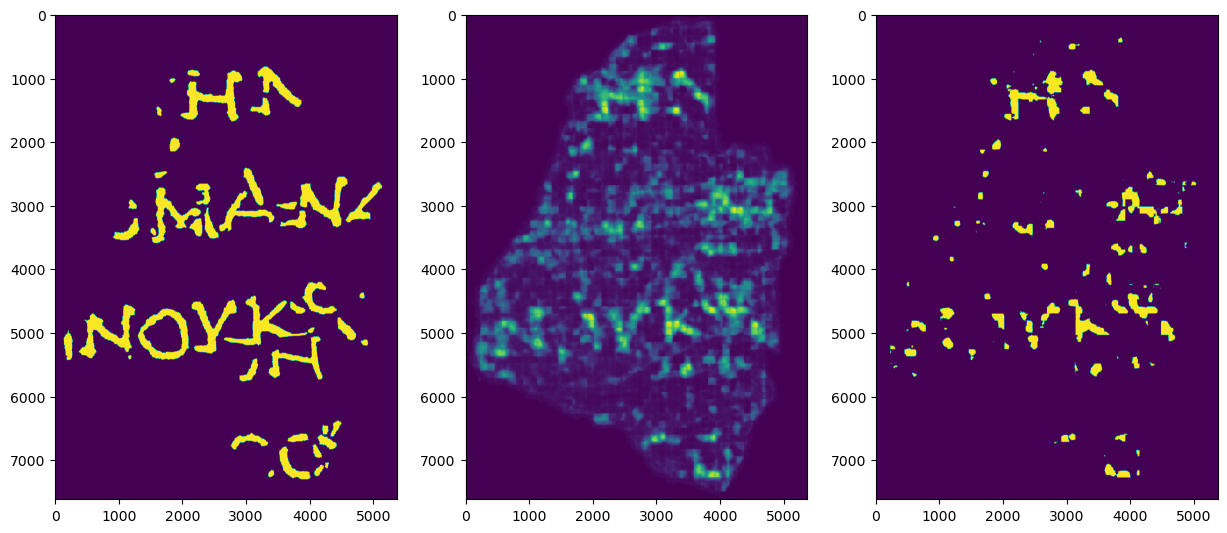

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([2.4680391e+07, 6.1671410e+06, 2.2499960e+06, 1.5957550e+06,
        1.2401330e+06, 9.9803600e+05, 8.7250700e+05, 6.7418600e+05,
        5.0909500e+05, 4.1379700e+05, 3.3863700e+05, 2.7360200e+05,
        2.3384900e+05, 2.1016200e+05, 1.7501300e+05, 1.3563400e+05,
        8.6235000e+04, 5.1971000e+04, 2.7132000e+04, 1.0344000e+04]),
 array([2.40268091e-05, 4.84721101e-02, 9.69201933e-02, 1.45368277e-01,
        1.93816360e-01, 2.42264443e-01, 2.90712526e-01, 3.39160610e-01,
        3.87608693e-01, 4.36056776e-01, 4.84504859e-01, 5.32952942e-01,
        5.81401026e-01, 6.29849109e-01, 6.78297192e-01, 7.26745275e-01,
        7.75193359e-01, 8.23641442e-01, 8.72089525e-01, 9.20537608e-01,
        9.68985692e-01]),
 <BarContainer object of 20 artists>)

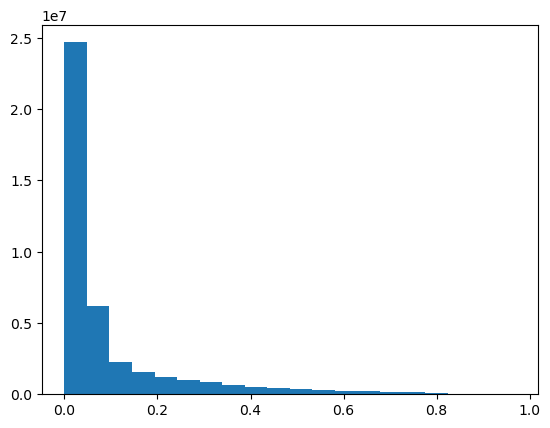

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000